<h1><center><font color='green'>Classifiez automatiquement des biens de consommation</font></center></h1>

## Objectif :

- L’entreprise "Place de marché”  souhaite lancer une marketplace e-commerce.
- Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.
- l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs.
- Pour rendre l’expérience utilisateur des vendeurs fluide il devient nécessaire d'automatiser cette tâche.
- Etudier la faisabilité d'un moteur de classification des articles en différentes catégories, avec un niveau de précision suffisant.

In [1]:
# importer les librairies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

In [2]:
df = pd.read_csv (r"C:\Users\chouc\Downloads\Dataset+projet+prétraitement+textes+images\Flipkart\flipkart_com-ecommerce_sample_1050.csv")

In [3]:
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [4]:
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [5]:
df.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [6]:
df.shape

(1050, 15)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [8]:
df.isnull().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

###  Définir les différentes catégories des produits :

In [9]:
df['product_category_tree'].unique()

array(['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]',
       '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]',
       '["Watches >> Wrist Watches >> Camerii Wrist Watches"]',
       '["Watches >> Wrist Watches >> T STAR Wrist Watches"]',
       '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]',
       '["Watches >> Wrist Watches >> T

In [10]:
df['product_category_tree'][1]

'["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]'

In [11]:
# Definition of a function to apply or map
def get_categories_from_series(series):
    
    # --------------------------------------
    # Function to get the 3 first categories
    def get_categories_from_cell(cell):
        # Remove unwanted chars
        product_category_tree = cell.strip('[]"')

        # Get (at most) the 3 first categories of the category tree
        product_categories_list = product_category_tree.split(" >> ")
        
        # Initialization
        categories = pd.Series()
        
        # for each category, add a row
        for i in range(min(3, len(product_categories_list))):
            categories["category_{}".format(i+1)] = product_categories_list[i]
        
        # return pd.Series with 3 rows
        return categories

    # ------------------------------------------------
    # Proceed to the split
    categories_df = series.apply(get_categories_from_cell).fillna("")

    # Return the frequency_encoding pd.DataFrame
    return categories_df

categories_df = get_categories_from_series(df['product_category_tree'])


# Add the columns of categories to the data DataFrame
df = pd.concat(
    [df, categories_df],
    sort=False,
    axis=1
)

# Display results
df.head(2)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2167768818.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future 

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   

                              product_specifications       category_1  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care   

               category_2        category_3  
0  Curtains & Accessories          Curtains  
1        Baby Bath & Skin  Baby Bath Towels

In [12]:
df[['description','product_name','brand','category_1','category_2','category_3']].head(10)

description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   
5  Maserati Time R8851116001 Analog Watch  - For ...   
6  Camerii WM64 Elegance Analog Watch  - For Men,...   
7  T STAR UFT-TSW-005-BK-BR Analog Watch  - For B...   
8  Alfajr WY16B Youth Digital Watch  - For Men, B...   
9  TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...   

                                        product_name                  brand  \
0  Elegance Polyester Multicolor Abstract Eyelet ...               Elegance   
1                         Sathiyas Cotton Bath Towel               Sathiyas   
2                Eurospa Cotton Terry Face Towel Set                Eurospa   
3  SANTOSH ROYAL FASHION Cotton Printed King size...  SANTOSH ROYAL FASHION   
4  Jaipur Print Cotton Floral King sized Double B...           Jaipur Print   
5  Maserati Time R8851116001 Analog Watch  - For ...                    NaN   
6  Camerii WM64 Elegance Analog Watch  - For Men,...                    NaN   
7  T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys                    NaN   
8  Alfajr WY16B Youth Digital Watch  - For Men, Boys                    NaN   
9  TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...                    NaN   

        category_1              category_2                   category_3  
0  Home Furnishing  Curtains & Accessories                     Curtains  
1        Baby Care        Baby Bath & Skin             Baby Bath Towels  
2        Baby Care        Baby Bath & Skin             Baby Bath Towels  
3  Home Furnishing               Bed Linen                    Bedsheets  
4  Home Furnishing               Bed Linen                    Bedsheets  
5          Watches           Wrist Watches  Maserati Time Wrist Watches  
6          Watches           Wrist Watches        Camerii Wrist Watches  
7          Watches           Wrist Watches         T STAR Wrist Watches  
8          Watches           Wrist Watches         Alfajr Wrist Watches  
9          Watches           Wrist Watches      TAG Heuer Wrist Watches

<AxesSubplot:ylabel='category_1'>

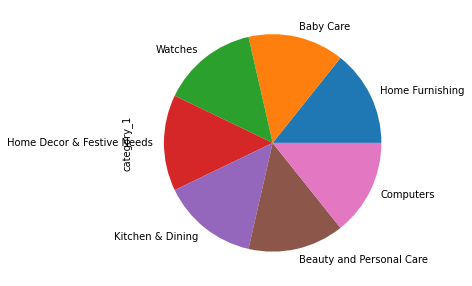

In [13]:
plt.figure(figsize=(5,5))
df['category_1'].value_counts().sort_values(ascending= False).plot.pie()

==> 7 grandes catégories de produits : 'Watches', 'Baby Care', 'Home Furnishing', 'Computers', 'Beauty and Personal Care', 'Kitchen & Dining', 'Home Decor & Festive Needs'. 

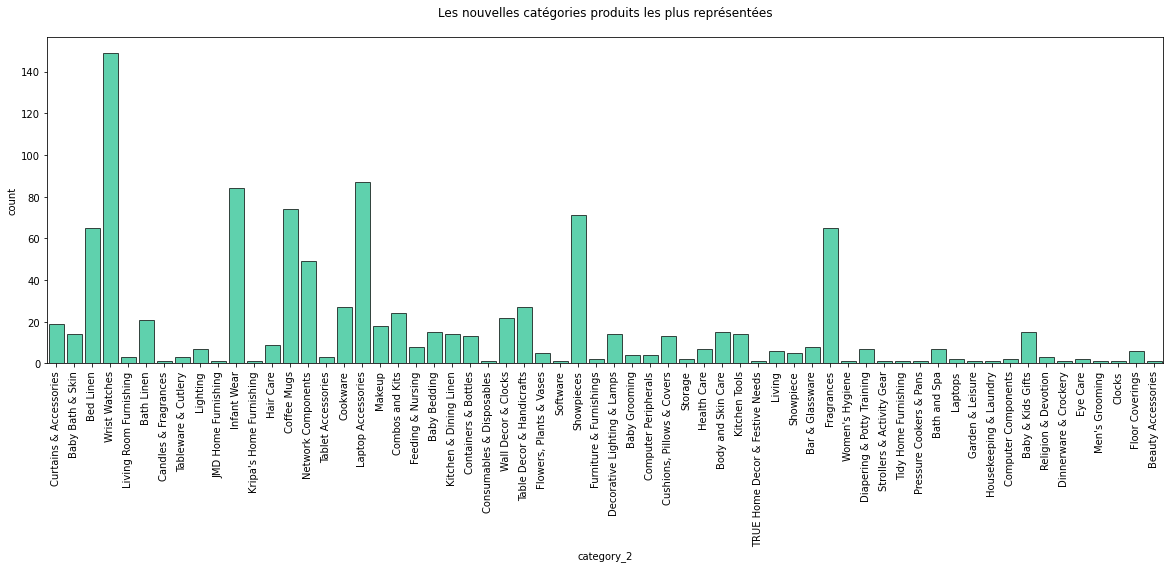

In [14]:
# Plot categories count in dataset
fig = plt.figure(figsize=(20, 6))
sns.countplot(data=df, x='category_2',
              edgecolor="black",
              color="#00d994", alpha=0.7)
plt.xticks(range(0, df['category_2'].nunique()),
           df['category_2'].unique(),
           rotation=90)
plt.title(f"Les nouvelles catégories produits les plus représentées\n")
plt.show()

<AxesSubplot:ylabel='category_3'>

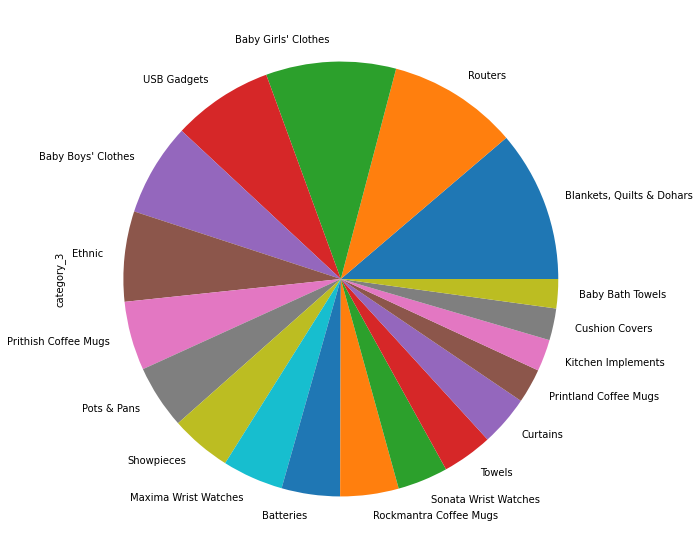

In [15]:
plt.figure(figsize=(10,10))
df['category_3'].value_counts().sort_values(ascending= False)[1:20].plot.pie()

## <font color='red'> - Preprocessing et extraction des features texte :</font> 

In [16]:
df['description'].unique()

array(['Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so t

In [17]:
df['description'].nunique()

1050

In [18]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s\�]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[^A-Za-z0-9.]+', ' ',text)
    return text

In [19]:
# Applying the cleaning function 
df['description_clean'] = df['description'].apply(lambda x: clean_text(x))

In [20]:
df['description_clean'].unique()

array(['key features of elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain cm in height pack of price rs this curtain enhances the look of the interiorsthis curtain is made from high quality polyester fabricit features an eyelet style stitch with metal ringit makes the room environment romantic and lovingthis curtain is ant wrinkle and anti shrinkage and have elegant apparancegive your home a bright and modernistic appeal with these designs the surreal attention is sure to steal hearts these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening you create the most special moments of joyous beauty given by the soothing prints bring home the elegant curtain that softly filters light in your room so that you get the right amount of

In [21]:
# Expand the Contractions

In [22]:
pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [23]:
%time
import contractions

df['description_clean_no_contraction'] = df['description_clean'].apply(lambda x: contractions.fix(x))

CPU times: total: 0 ns
Wall time: 0 ns


## Text Preprocessing:

#### Tokenization

In [24]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chouc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
df['description_tokenized'] = df['description_clean_no_contraction'].apply(word_tokenize)
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product  ...       product_rating       overall_rating  \
0                    False  ...  No rating available  No rating available   
1                    False  ...  No rating available  No rating available   
2                    False  ...  No rating available  No rating available   
3                    False  ...  No rating available  No rating available   
4                    False  ...  No rating available  No rating available   

                   brand                             product_specifications  \
0               Elegance  {"product_specification"=>[{"key"=>"Brand", "v...   
1               Sathiyas  {"product_specification"=>[{"key"=>"Machine Wa...   
2                Eurospa  {"product_specification"=>[{"key"=>"Material",...   
3  SANTOSH ROYAL FASHION  {"product_specification"=>[{"key"=>"Brand", "v...   
4           Jaipur Print  {"product_specification"=>[{"key"=>"Machine Wa...   

        category_1              category_2        category_3  \
0  Home Furnishing  Curtains & Accessories          Curtains   
1        Baby Care        Baby Bath & Skin  Baby Bath Towels   
2        Baby Care        Baby Bath & Skin  Baby Bath Towels   
3  Home Furnishing               Bed Linen         Bedsheets   
4  Home Furnishing               Bed Linen         Bedsheets   

                                   description_clean  \
0  key features of elegance polyester multicolor ...   
1  specifications of sathiyas cotton bath towel b...   
2  key features of eurospa cotton terry face towe...   
3  key features of santosh royal fashion cotton p...   
4  key features of jaipur print cotton floral kin...   

                    description_clean_no_contraction  \
0  key features of elegance polyester multicolor ...   
1  specifications of sathiyas cotton bath towel b...   
2  key features of eurospa cotton terry face towe...   
3  key features of santosh royal fashion cotton p...   
4  key features of jaipur print cotton floral kin...   

                               description_tokenized  
0  [key, 

#### Remove Stop Words (or/and Frequent words/ Rare words):

In [26]:
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chouc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
stop = set(stopwords.words('english'))
df['description_tokenized_sp_removed'] = df['description_tokenized'].apply(lambda x: [word for word in x if word not in stop])
df['description_tokenized_sp_removed'].head()

0    [key, features, elegance, polyester, multicolo...
1    [specifications, sathiyas, cotton, bath, towel...
2    [key, features, eurospa, cotton, terry, face, ...
3    [key, features, santosh, royal, fashion, cotto...
4    [key, features, jaipur, print, cotton, floral,...
Name: description_tokenized_sp_removed, dtype: object

#### Part of Speech Tagging (POS Tagging):

In [28]:
from nltk.corpus import wordnet
from nltk.corpus import brown
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('brown')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chouc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\chouc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\chouc\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [29]:
wordnet_map = {"N":wordnet.NOUN, 
               "V":wordnet.VERB, 
               "J":wordnet.ADJ, 
               "R":wordnet.ADV
              }
train_sents = brown.tagged_sents(categories='news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)

In [30]:
def pos_tag_wordnet(text, pos_tag_type="pos_tag"):
    """
        Create pos_tag with wordnet format
    """
    pos_tagged_text = t2.tag(text)
    
    # map the pos tagging output with wordnet output 
    pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text ]
    return pos_tagged_text

In [31]:
%time 

df['description_tokenized_sp_removed_postag'] = df['description_tokenized_sp_removed'].apply(lambda x: pos_tag_wordnet(x))

df['description_tokenized_sp_removed_postag'].head()

CPU times: total: 0 ns
Wall time: 0 ns


0    [(key, n), (features, v), (elegance, n), (poly...
1    [(specifications, n), (sathiyas, n), (cotton, ...
2    [(key, n), (features, v), (eurospa, n), (cotto...
3    [(key, n), (features, v), (santosh, n), (royal...
4    [(key, n), (features, v), (jaipur, n), (print,...
Name: description_tokenized_sp_removed_postag, dtype: object

#### Lemmatization:

In [32]:
from nltk.stem import WordNetLemmatizer

def lemmatize_word(text):
    """
        Lemmatize the tokenized words
    """

    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemma

In [33]:
# Lemmatization with POS Tagging:

In [34]:
%time 

# Test with POS Tagging
lemmatizer = WordNetLemmatizer()

df['lemmatize_word_w_pos'] = df['description_tokenized_sp_removed_postag'].apply(lambda x: lemmatize_word(x))
df['lemmatize_word_w_pos'] = df['lemmatize_word_w_pos'].apply(lambda x: [word for word in x if word not in stop]) # double check to remove stop words
df['lemmatize_text'] = [' '.join(map(str, l)) for l in df['lemmatize_word_w_pos']] # join back to text

df['lemmatize_text'].head()

CPU times: total: 0 ns
Wall time: 0 ns


0    key feature elegance polyester multicolor abst...
1    specification sathiyas cotton bath towel bath ...
2    key feature eurospa cotton terry face towel se...
3    key feature santosh royal fashion cotton print...
4    key feature jaipur print cotton floral king si...
Name: lemmatize_text, dtype: object

In [35]:
#Comparison between original text and the lammatized text:

In [36]:
display(df["description"][5], df["lemmatize_text"][5])
display(df["description"][200], df["lemmatize_text"][200])
display(df["description"][450], df["lemmatize_text"][450])
display(df["description"][369], df["lemmatize_text"][369])

'Maserati Time R8851116001 Analog Watch  - For Boys - Buy Maserati Time R8851116001 Analog Watch  - For Boys  R8851116001 Online at Rs.24400 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!'

'maserati time analog watch boy buy maserati time analog watch boy online india flipkartcom great discount genuine product day replacement guarantee free shipping cash delivery'

'MA Design Hut Showpiece  -  8 cm (Brass, Yellow)\r\n                         Price: Rs. 399\r\n\t\t\t\t\r\n\t\t\tDecorative Gift Item Canon\r\nDecorative Gift Item Canon'

'design hut showpiece cm brass yellow price r decorative gift item canon decorative gift item canon'

"Specifications of Upside Down Sleeveless Applique Baby Girl's, Baby Boy's Jacket General Details Ideal For Baby Girl's, Baby Boy's Pattern Applique Jacket Details Fabric Poly Cotton Reversible No Hooded No Closure Buttons Sleeve Sleeveless Lining Cotton Fabric Care Dont Wash With Other Garments, Hand Wash With Mild Detergent,Dont Tumble Dry, Dry In Shade. Additional Details Style Code LIGHT PINK SMILEY FACE JACKET Other Details Sleeveless In the Box 1 Jacket"

'specification upside sleeveless applique baby girl baby boy jacket general detail ideal baby girl baby boy pattern applique jacket detail fabric poly cotton reversible hooded closure button sleeve sleeveless line cotton fabric care wash garment hand wash mild detergentdont tumble dry dry shade additional detail style code light pink smiley face jacket detail sleeveless box jacket'

'Buy Tenda 3G300M only for Rs. 3000 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!'

'buy tenda r flipkartcom genuine product day replacement guarantee free shipping cash delivery'

## Text Features Extraction:


#### Weighted Words - Bag of Words (BoW) - Bag of n-grams:

In [37]:
# Frequency Vectors - CountVectorizer:

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

def cv(data, ngram1=1, ngram2 = 1, MAX_NB_WORDS = 75000,):
    count_vectorizer = CountVectorizer(ngram_range = (ngram1, ngram2), max_features = MAX_NB_WORDS)
    emb = count_vectorizer.fit_transform(data).toarray()
    print("count vectorize with", str(np.array(emb).shape[1]), "features")
    return emb, count_vectorizer

In [39]:
def print_out(emb, feat, ngram, compared_sentence=0):
    print(ngram,"bag-of-words: ")
    print(feat.get_feature_names(), "\n")
    print(ngram,"bag-of-feature: ")
    print(test_cv_1gram.vocabulary_, "\n")
    print("BoW matrix:")
    print(pd.DataFrame(emb.transpose(), index = feat.get_feature_names()).head(), "\n")
    print(ngram,"vector example:")
    print(df['lemmatize_text'][compared_sentence])
    print(emb[compared_sentence], "\n")

In [40]:
# test
test_corpus = df['lemmatize_text'][:5].tolist()
print("The test corpus: ", test_corpus, "\n")

test_cv_em_1gram, test_cv_1gram = cv(test_corpus, ngram1=1, ngram2 = 1)
print_out(test_cv_em_1gram, test_cv_1gram, ngram="Uni-gram")

The test corpus:  ['key feature elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain cm height pack price r curtain enhances look interiorsthis curtain make high quality polyester fabricit feature eyelet style stitch metal ringit make room environment romantic lovingthis curtain ant wrinkle anti shrinkage elegant apparancegive home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty give soothing print bring home elegant curtain softly filter light room get right amount sunlightspecifications elegance polyester multicolor abstract eyelet door curtain cm height pack general brand elegance design door type eyelet model name abstract polyester door curtain set model id color multicolor dimension length c

C:\Users\chouc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [41]:
test_cv_em_2gram, test_cv_2gram = cv(test_corpus, ngram1=1, ngram2 =2)
print_out(test_cv_em_2gram, test_cv_2gram, ngram="Bi-gram")

count vectorize with 595 features
Bi-gram bag-of-words: 
['absorbency', 'absorbency softness', 'abstract', 'abstract eyelet', 'abstract polyester', 'amount', 'amount sunlightspecifications', 'ant', 'ant wrinkle', 'anti', 'anti shrinkage', 'apart', 'apart first', 'apparancegive', 'apparancegive home', 'appeal', 'appeal design', 'assorted', 'assorted bath', 'assorted dimension', 'assorted price', 'attention', 'attention sure', 'bath', 'bath towel', 'beauty', 'beauty give', 'bed', 'bed sheet', 'bedsheet', 'bedsheet bed', 'bedsheet cottonjaipur', 'bedsheet give', 'bedsheet long', 'bedsheet perfact', 'bedsheet pillow', 'bedsheet royal', 'bleach', 'bleach dimension', 'bleach flat', 'bleach size', 'blue', 'blue bath', 'blue size', 'body', 'body design', 'box', 'box number', 'boy', 'boy girl', 'brand', 'brand elegance', 'brand eurospa', 'brand jaipur', 'brand last', 'brand santosh', 'brand sathiyas', 'bright', 'bright modernistic', 'bright sun', 'bring', 'bring exclusively', 'bring home', 'car

C:\Users\chouc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
test_cv_em_3gram, test_cv_3gram = cv(test_corpus, ngram1=1, ngram2 =3)
print_out(test_cv_em_3gram, test_cv_3gram, ngram="Tri-gram")

count vectorize with 1062 features
Tri-gram bag-of-words: 
['absorbency', 'absorbency softness', 'absorbency softness durability', 'abstract', 'abstract eyelet', 'abstract eyelet door', 'abstract polyester', 'abstract polyester door', 'amount', 'amount sunlightspecifications', 'amount sunlightspecifications elegance', 'ant', 'ant wrinkle', 'ant wrinkle anti', 'anti', 'anti shrinkage', 'anti shrinkage elegant', 'apart', 'apart first', 'apart first thing', 'apparancegive', 'apparancegive home', 'apparancegive home bright', 'appeal', 'appeal design', 'appeal design surreal', 'assorted', 'assorted bath', 'assorted bath towel', 'assorted dimension', 'assorted dimension weight', 'assorted price', 'assorted price eurospa', 'attention', 'attention sure', 'attention sure steal', 'bath', 'bath towel', 'bath towel bath', 'bath towel feature', 'bath towel gsm', 'bath towel ideal', 'bath towel lot', 'bath towel red', 'beauty', 'beauty give', 'beauty give soothing', 'bed', 'bed sheet', 'bed sheet ha

C:\Users\chouc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [43]:
%time 

# implement into the whole dataset
df_corpus = df['lemmatize_text'].tolist()
df_em_1gram, vc_1gram = cv(df_corpus, 1,1)
df_em_2gram, vc_2gram = cv(df_corpus, 1,2)
df_em_3gram, vc_3gram = cv(df_corpus, 1,3)

print(len(df_corpus))
print(df_em_1gram.shape)
print(df_em_2gram.shape)
print(df_em_3gram.shape)


CPU times: total: 0 ns
Wall time: 0 ns
count vectorize with 4619 features
count vectorize with 21948 features
count vectorize with 44196 features
1050
(1050, 4619)
(1050, 21948)
(1050, 44196)


In [44]:
# del df_em_1gram, df_em_2gram, df_em_3gram

##### PCA et clustering Bag of Words (BoW) - Bag of 1-grams

In [45]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from transformers import pipeline

In [46]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

In [47]:
# PCA Pipeline
pca =  PCA(svd_solver='full')
            
pca.fit(df_em_1gram)
X_projected = pca.transform(df_em_1gram)

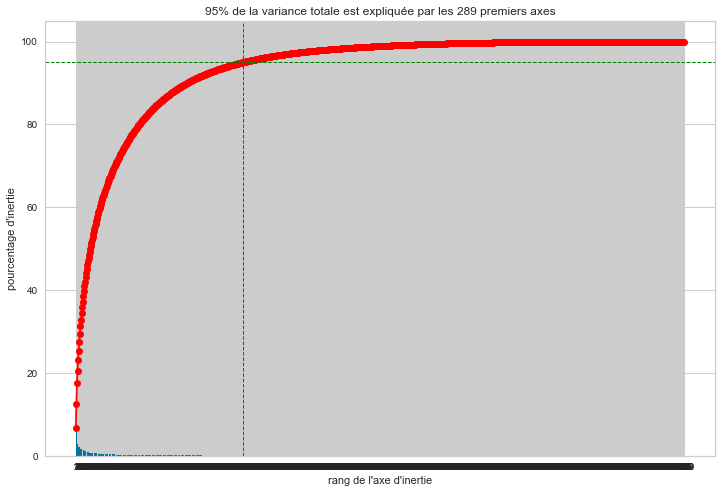

In [48]:
# Explained variance
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [49]:

cls = KMeans(n_clusters=7, random_state=0)
cls.fit(X_projected)

KMeans(n_clusters=7, random_state=0)

In [50]:
# predict cluster labels for new dataset
cls.predict(X_projected)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([1, 1, 1, ..., 0, 0, 0])

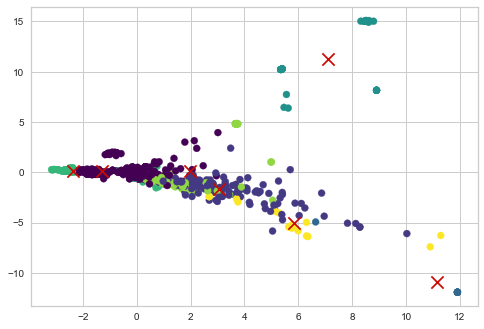

In [51]:
plt.scatter(X_projected[:,0], X_projected[:,1], c=cls.predict(X_projected), cmap='viridis')
plt.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:,1], marker='x', s=150, c='r')

##### PCA et clustering Bag of Words (BoW) - Bag of 3-grams

In [52]:
# PCA Pipeline
pca =  PCA(svd_solver='full')
            
pca.fit(df_em_3gram)
X_projected = pca.transform(df_em_3gram)

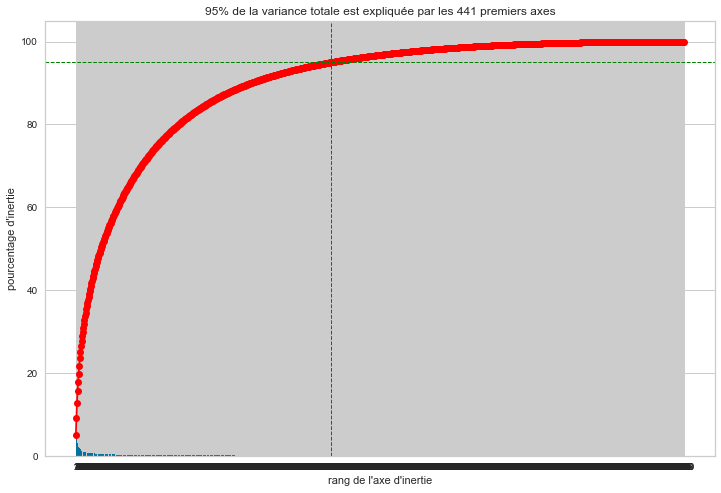

In [53]:
# Explained variance
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [54]:
cls = KMeans(n_clusters=7, random_state=0)
cls.fit(X_projected)

KMeans(n_clusters=7, random_state=0)

In [55]:
# predict cluster labels for new dataset
cls.predict(X_projected)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([5, 5, 5, ..., 0, 0, 0])

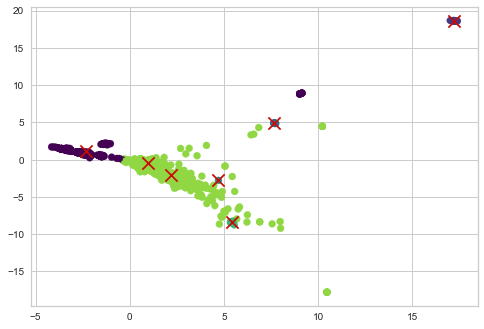

In [56]:
plt.scatter(X_projected[:,0], X_projected[:,1], c=cls.predict(X_projected), cmap='viridis')
plt.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:,1], marker='x', s=150, c='r')

#### Term Frequency-Inverse Document Frequency (TF-IDF):

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

def TFIDF(data, ngram = 1, MAX_NB_WORDS = 75000):
    tfidf_x = TfidfVectorizer(ngram_range = (ngram, ngram), max_features = MAX_NB_WORDS)
    emb = tfidf_x.fit_transform(data).toarray()
    print("tf-idf with", str(np.array(emb).shape[1]), "features")
    return emb, tfidf_x

In [58]:
test_corpus = df["lemmatize_text"][:5].tolist()
print("The test corpus: ", test_corpus, "\n")

test_tfidf_em_1gram, test_tfidf_1gram = TFIDF(test_corpus, ngram=1)
print_out(test_tfidf_em_1gram, test_tfidf_1gram, ngram="Uni-gram")

The test corpus:  ['key feature elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain cm height pack price r curtain enhances look interiorsthis curtain make high quality polyester fabricit feature eyelet style stitch metal ringit make room environment romantic lovingthis curtain ant wrinkle anti shrinkage elegant apparancegive home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty give soothing print bring home elegant curtain softly filter light room get right amount sunlightspecifications elegance polyester multicolor abstract eyelet door curtain cm height pack general brand elegance design door type eyelet model name abstract polyester door curtain set model id color multicolor dimension length c

C:\Users\chouc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [59]:
test_tfidf_em_2gram, test_tfidf_2gram = TFIDF(test_corpus, ngram=2)
print_out(test_tfidf_em_2gram, test_tfidf_2gram, ngram="Bi-gram")

tf-idf with 392 features
Bi-gram bag-of-words: 
['absorbency softness', 'abstract eyelet', 'abstract polyester', 'amount sunlightspecifications', 'ant wrinkle', 'anti shrinkage', 'apart first', 'apparancegive home', 'appeal design', 'assorted bath', 'assorted dimension', 'assorted price', 'attention sure', 'bath towel', 'beauty give', 'bed sheet', 'bedsheet bed', 'bedsheet cottonjaipur', 'bedsheet give', 'bedsheet long', 'bedsheet perfact', 'bedsheet pillow', 'bedsheet royal', 'bleach dimension', 'bleach flat', 'bleach size', 'blue bath', 'blue size', 'body design', 'box number', 'boy girl', 'brand elegance', 'brand eurospa', 'brand jaipur', 'brand last', 'brand santosh', 'brand sathiyas', 'bright modernistic', 'bright sun', 'bring exclusively', 'bring home', 'care machine', 'care machinewash', 'care skin', 'care wash', 'close evening', 'cm box', 'cm cmsspecifications', 'cm fit', 'cm flat', 'cm height', 'cm pillow', 'cm weight', 'cmsspecifications eurospa', 'cold water', 'color assorte

C:\Users\chouc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [60]:
test_tfidf_em_3gram, test_tfidf_3gram = TFIDF(test_corpus, ngram=3)
print_out(test_tfidf_em_3gram, test_tfidf_3gram, ngram="Tri-gram")

tf-idf with 467 features
Tri-gram bag-of-words: 
['absorbency softness durability', 'abstract eyelet door', 'abstract polyester door', 'amount sunlightspecifications elegance', 'ant wrinkle anti', 'anti shrinkage elegant', 'apart first thing', 'apparancegive home bright', 'appeal design surreal', 'assorted bath towel', 'assorted dimension weight', 'assorted price eurospa', 'attention sure steal', 'bath towel bath', 'bath towel feature', 'bath towel gsm', 'bath towel ideal', 'bath towel lot', 'bath towel red', 'beauty give soothing', 'bed sheet hand', 'bed sheet make', 'bed sheet pillow', 'bedsheet bed sheet', 'bedsheet cottonjaipur print', 'bedsheet give nice', 'bedsheet long lifespecifications', 'bedsheet perfact wedding', 'bedsheet pillow cover', 'bedsheet royal bedsheet', 'bleach dimension flat', 'bleach flat dry', 'bleach size king', 'blue bath towel', 'blue size mediam', 'body design material', 'box number content', 'boy girl men', 'boy girl model', 'brand elegance design', 'brand

C:\Users\chouc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [61]:
%time 

# implement into the whole dataset
df_corpus = df["lemmatize_text"].tolist()
df_tfidf_1gram, tfidf_1gram = TFIDF(df_corpus, 1)
df_tfidf_2gram, tfidf_2gram = TFIDF(df_corpus, 2)
df_tfidf_3gram, tfidf_3gram = TFIDF(df_corpus, 3)

print(len(df_corpus))
print(df_tfidf_1gram.shape)
print(df_tfidf_2gram.shape)
print(df_tfidf_3gram.shape)

CPU times: total: 0 ns
Wall time: 0 ns
tf-idf with 4619 features
tf-idf with 17329 features
tf-idf with 22248 features
1050
(1050, 4619)
(1050, 17329)
(1050, 22248)


In [62]:
# del df_tfidf_1gram, df_tfidf_2gram, df_tfidf_3gram

#### PCA et clustering tfidf_1gram

In [63]:

# PCA Pipeline
pca =  PCA(svd_solver='full')
            
pca.fit(df_tfidf_1gram)
X_projected = pca.transform(df_tfidf_1gram)

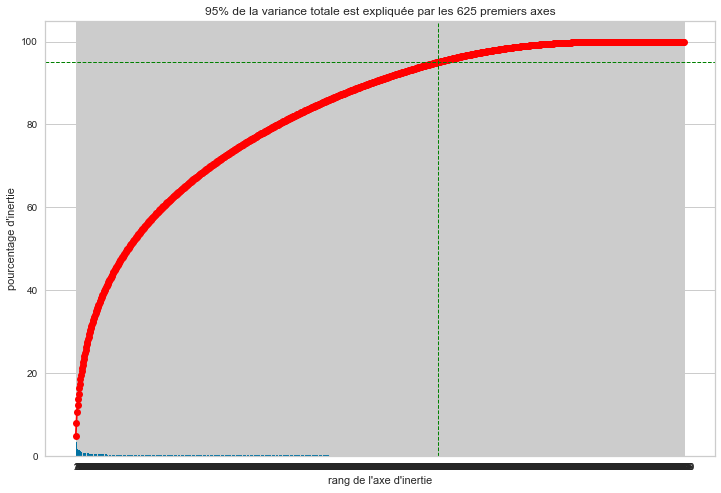

In [64]:
# Explained variance
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [65]:
cls = KMeans(n_clusters=7, random_state=0)
cls.fit(X_projected)

KMeans(n_clusters=7, random_state=0)

In [66]:
# predict cluster labels for new dataset
cls.predict(X_projected)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([0, 0, 0, ..., 0, 0, 0])

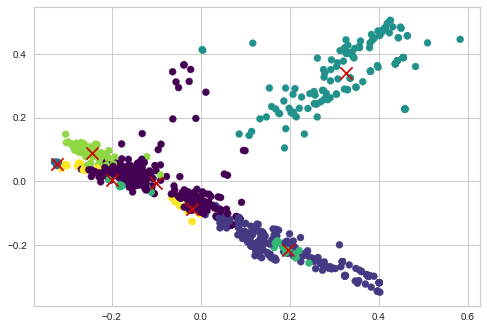

In [67]:
plt.scatter(X_projected[:,0], X_projected[:,1], c=cls.predict(X_projected), cmap='viridis')
plt.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:,1], marker='x', s=150, c='r')

#### PCA et clustering tfidf_3gram

In [68]:
# PCA Pipeline
pca =  PCA(svd_solver='full')
            
pca.fit(df_tfidf_3gram)
X_projected = pca.transform(df_tfidf_3gram)

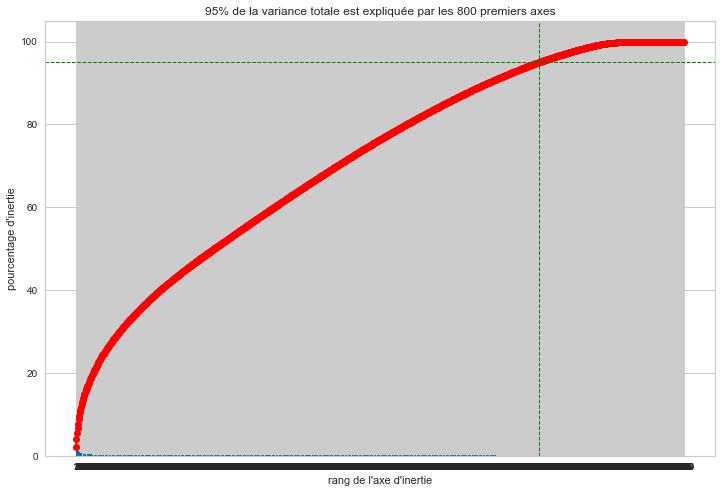

In [69]:
# Explained variance
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [70]:
cls = KMeans(n_clusters=7, random_state=0)
cls.fit(X_projected)

KMeans(n_clusters=7, random_state=0)

In [71]:
# predict cluster labels for new dataset
cls.predict(X_projected)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([2, 2, 2, ..., 4, 4, 4])

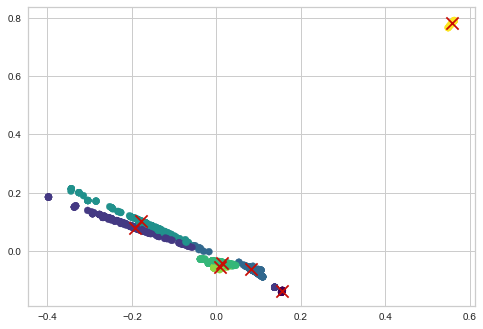

In [72]:
plt.scatter(X_projected[:,0], X_projected[:,1], c=cls.predict(X_projected), cmap='viridis')
plt.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:,1], marker='x', s=150, c='r')

#### Word Embedding:

Word2Vec:

In [73]:
%time 

import gensim
print("gensim version:", gensim.__version__)

word2vec_path = "./GoogleNews-vectors-negative300.bin"

# we only load 200k most common words from Google News corpus 
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=200000) 

CPU times: total: 0 ns
Wall time: 0 ns
gensim version: 4.1.2


In [74]:
#Example
#Compare the similarity between "cat" vs. "kitten" and "cat" vs. "cats" from FastText
print(word2vec_model.similarity('cat', 'kitten'))
print(word2vec_model.similarity('cat', 'cats'))

0.74649847
0.8099379


In [75]:
def get_average_vec(tokens_list, vector, generate_missing=False, k=300):
    """
        Calculate average embedding value of sentence from each word vector
    """
    
    if len(tokens_list)<1:
        return np.zeros(k)
    
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_embeddings(vectors, text, generate_missing=False, k=300):
    """
        create the sentence embedding
    """
    embeddings = text.apply(lambda x: get_average_vec(x, vectors, generate_missing=generate_missing, k=k))
    return list(embeddings)

In [76]:
%time 

embeddings_word2vec = get_embeddings(word2vec_model, df["lemmatize_text"], k=300)

print("Embedding matrix size", len(embeddings_word2vec), len(embeddings_word2vec[0]))
print("The sentence: \"%s\" got embedding values: " % df["lemmatize_text"][0])
print(embeddings_word2vec[0])

CPU times: total: 0 ns
Wall time: 0 ns
Embedding matrix size 1050 300
The sentence: "key feature elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain cm height pack price r curtain enhances look interiorsthis curtain make high quality polyester fabricit feature eyelet style stitch metal ringit make room environment romantic lovingthis curtain ant wrinkle anti shrinkage elegant apparancegive home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty give soothing print bring home elegant curtain softly filter light room get right amount sunlightspecifications elegance polyester multicolor abstract eyelet door curtain cm height pack general brand elegance design door type eyelet model name abstract polyes

In [77]:
# del embeddings_word2vec

#### PCA et clustering word2vec

In [78]:
# PCA Pipeline
pca =  PCA(svd_solver='full')
            
pca.fit(embeddings_word2vec)
X_projected = pca.transform(embeddings_word2vec)

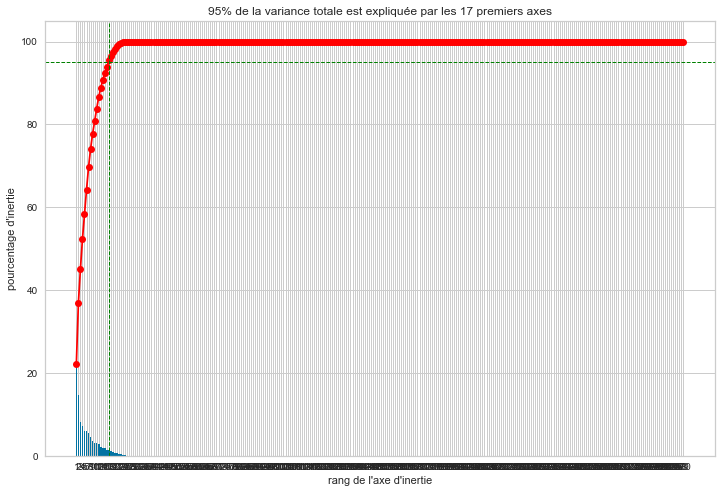

In [79]:
# Explained variance
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [80]:
cls = KMeans(n_clusters=7, random_state=0)
cls.fit(X_projected)

KMeans(n_clusters=7, random_state=0)

In [81]:
# predict cluster labels for new dataset
cls.predict(X_projected)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([3, 3, 0, ..., 4, 6, 4])

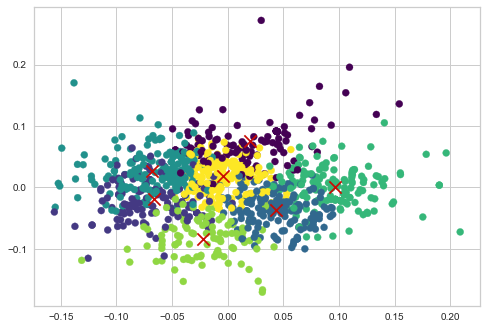

In [82]:
plt.scatter(X_projected[:,0], X_projected[:,1], c=cls.predict(X_projected), cmap= 'viridis')
plt.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:,1], marker='x', s=150, c='r')

#### Bidirectional Encoder Representations from Transformers (BERT):

In [83]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [84]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.0
2.10.0
Num GPUs Available:  0
True


In [85]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [86]:
# l=sentences.split('. ')
m=[len(i.split()) for i in df['lemmatize_text']]
m.sort(reverse=True)
m

[360,
 348,
 263,
 257,
 250,
 231,
 229,
 228,
 228,
 226,
 226,
 226,
 226,
 226,
 226,
 224,
 224,
 215,
 211,
 209,
 203,
 202,
 196,
 196,
 196,
 193,
 192,
 192,
 179,
 172,
 172,
 172,
 165,
 164,
 164,
 163,
 162,
 162,
 161,
 158,
 157,
 157,
 156,
 153,
 153,
 151,
 151,
 151,
 150,
 149,
 148,
 148,
 148,
 147,
 147,
 144,
 137,
 137,
 136,
 135,
 135,
 135,
 135,
 134,
 134,
 134,
 134,
 133,
 133,
 133,
 133,
 133,
 132,
 132,
 132,
 130,
 130,
 129,
 129,
 128,
 128,
 128,
 128,
 127,
 127,
 127,
 127,
 126,
 126,
 126,
 126,
 126,
 126,
 124,
 124,
 123,
 123,
 123,
 123,
 121,
 120,
 120,
 118,
 116,
 116,
 116,
 116,
 116,
 115,
 115,
 114,
 114,
 114,
 114,
 113,
 113,
 113,
 113,
 112,
 112,
 112,
 111,
 111,
 111,
 111,
 110,
 110,
 109,
 108,
 108,
 108,
 108,
 108,
 108,
 107,
 107,
 106,
 106,
 105,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 104,
 102,
 101,
 101,
 99,
 99,
 98,
 98,
 97,
 97,
 97,
 96,
 96,
 95,
 94,
 93,
 92,
 92,
 91,
 91,
 91,
 91,
 90,
 90,


In [87]:
max(m)

360

In [88]:
mean_m = sum(m) / len(m)
mean_m

51.06285714285714

In [89]:
max_length = 360
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df["lemmatize_text"].to_list()

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\chouc/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-u

In [90]:
# Création des features
import time
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\chouc/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

1/1 [==============================] - 6s 6s/step
temps traitement :  563.0


In [91]:
features_bert

array([[-0.01894021,  0.01365054,  0.6402263 , ...,  0.02718144,
        -0.14365333, -0.08701488],
       [ 0.0641147 , -0.10839881,  0.4010576 , ..., -0.09669249,
        -0.10369846,  0.05566568],
       [ 0.03953349, -0.05569459,  0.46744537, ..., -0.1085772 ,
        -0.21071796, -0.04914706],
       ...,
       [ 0.21431477, -0.12273208,  0.254114  , ...,  0.07767292,
        -0.16719715, -0.19066343],
       [ 0.2871141 , -0.17442682,  0.12175788, ...,  0.19328001,
        -0.22263701, -0.2731021 ],
       [ 0.31138244, -0.23220399,  0.21297298, ...,  0.08925121,
        -0.2154139 , -0.23007609]], dtype=float32)

### PCA et clustering Bert

In [92]:
# PCA Pipeline
pca =  PCA(svd_solver='full')
            
pca.fit(features_bert)
X_projected = pca.transform(features_bert)

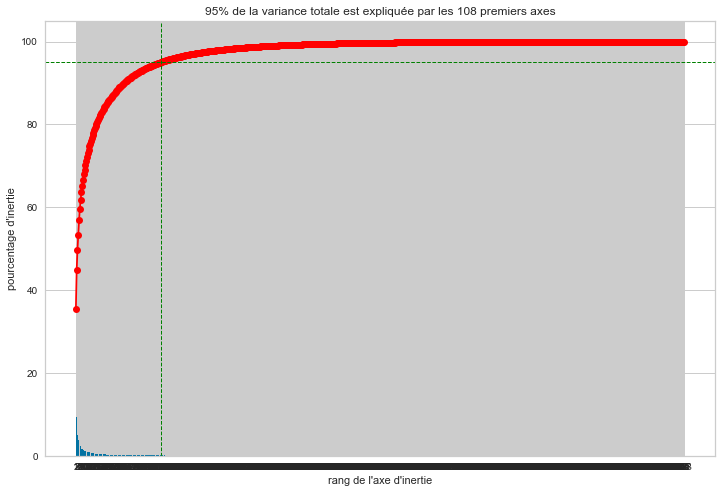

In [93]:
# Explained variance
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [94]:
cls = KMeans(n_clusters=7, random_state=0)
cls.fit(X_projected)

KMeans(n_clusters=7, random_state=0)

In [95]:
# predict cluster labels for new dataset
cls.predict(X_projected)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([1, 3, 1, ..., 2, 2, 2])

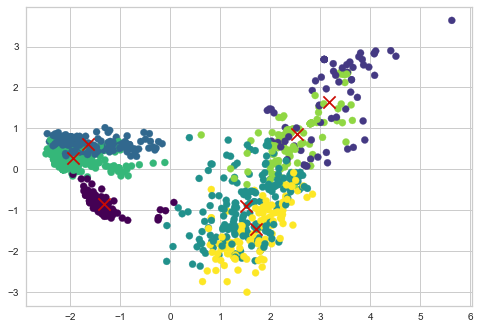

In [96]:
plt.scatter(X_projected[:,0], X_projected[:,1], c=cls.predict(X_projected), cmap='viridis')
plt.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:,1], marker='x', s=150, c='r')

#### USE - Universal Sentence Encoder

In [97]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [98]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.0
2.10.0
Num GPUs Available:  0
True


In [99]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [100]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [101]:
batch_size = 10
sentences = df["lemmatize_text"].to_list()

In [102]:
features_USE = feature_USE_fct(sentences, batch_size)

##### PCA et clustering USE

In [103]:
# PCA Pipeline
pca =  PCA(svd_solver='full')
            
pca.fit(features_USE)
X_projected = pca.transform(features_USE)

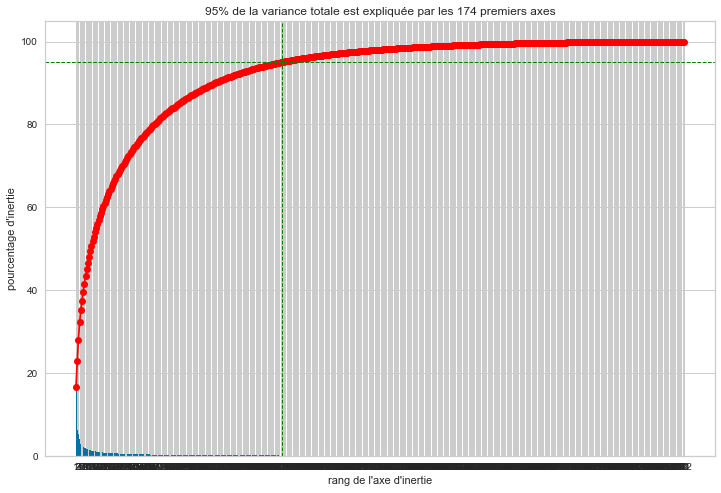

In [104]:
# Explained variance
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [105]:
cls = KMeans(n_clusters=7, random_state=0)
cls.fit(X_projected)

KMeans(n_clusters=7, random_state=0)

In [106]:
# predict cluster labels for new dataset
cls.predict(X_projected)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([3, 3, 5, ..., 4, 4, 4])

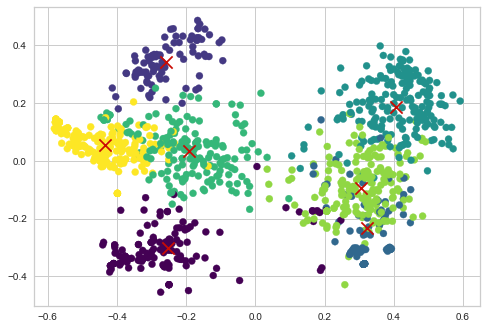

In [107]:
plt.scatter(X_projected[:,0], X_projected[:,1], c=cls.predict(X_projected), cmap='viridis')
plt.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:,1], marker='x', s=150, c='r')

### calcul de similarité entre les catégories réelles et les clusters

In [108]:
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


In [109]:
l_cat = list(set(df['category_1']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df.iloc[i]['category_1'])) for i in range(len(df))]

catégories :  ['Home Decor & Festive Needs', 'Watches', 'Computers', 'Kitchen & Dining', 'Baby Care', 'Home Furnishing', 'Beauty and Personal Care']


In [110]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features, tsne_perplexity) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=tsne_perplexity, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("[ARI_fct] ", "perplexity :",tsne_perplexity ,"  ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des catégories par clusters')
    
    plt.show()
    print("ARI : ", ARI)

### Score ARI : Bag of Words (BoW) - Bag of 1-grams

In [111]:
ARI_results = {}
for i in [5, 10, 20, 30, 40]:
    ARI, X_tsne, labels = ARI_fct(df_em_1gram, i )
    ARI_results[i] = {'ARI': ARI,'X_tsne' : X_tsne, 'labels': labels}
    
# print(ARI_results)

[ARI_fct]  perplexity : 5   ARI :  0.3257 time :  9.0
[ARI_fct]  perplexity : 10   ARI :  0.4019 time :  8.0
[ARI_fct]  perplexity : 20   ARI :  0.4193 time :  9.0
[ARI_fct]  perplexity : 30   ARI :  0.4519 time :  11.0
[ARI_fct]  perplexity : 40   ARI :  0.4205 time :  13.0


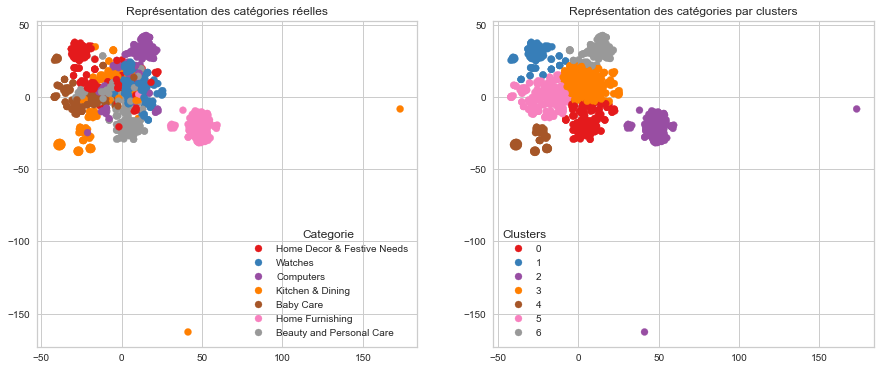

ARI :  0.4519


In [112]:
perplexity = 30
TSNE_visu_fct(ARI_results[perplexity]['X_tsne'], y_cat_num, ARI_results[perplexity]['labels'], ARI_results[perplexity]['ARI'])

### Score ARI : Bag of Words (BoW) - Bag of 3-grams

In [113]:
ARI_results = {}
for i in [5, 10, 20, 30, 40]:
    ARI, X_tsne, labels = ARI_fct(df_em_3gram, i )
    ARI_results[i] = {'ARI': ARI,'X_tsne' : X_tsne, 'labels': labels}
    
# print(ARI_results)


[ARI_fct]  perplexity : 5   ARI :  0.2851 time :  10.0
[ARI_fct]  perplexity : 10   ARI :  0.3091 time :  12.0
[ARI_fct]  perplexity : 20   ARI :  0.3433 time :  11.0
[ARI_fct]  perplexity : 30   ARI :  0.3703 time :  13.0
[ARI_fct]  perplexity : 40   ARI :  0.3738 time :  14.0


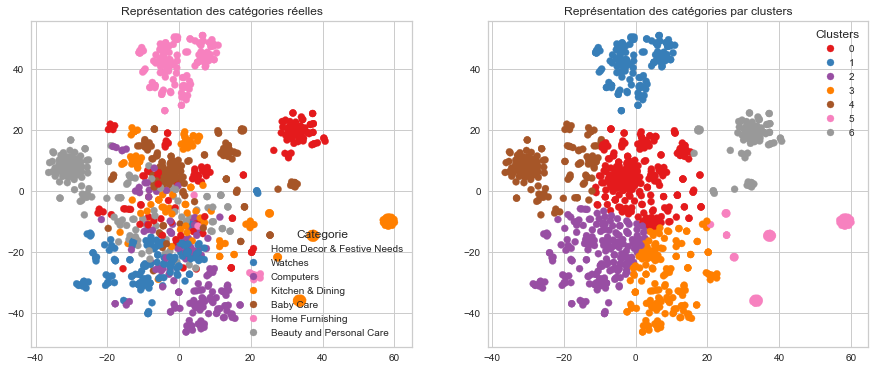

ARI :  0.3703


In [114]:
perplexity = 30
TSNE_visu_fct(ARI_results[perplexity]['X_tsne'], y_cat_num, ARI_results[perplexity]['labels'], ARI_results[perplexity]['ARI'])

### Score ARI :tfidf_1gram

In [115]:
ARI_results = {}
for i in [5, 10, 20, 30, 40]:
    ARI, X_tsne, labels = ARI_fct(df_tfidf_1gram, i )
    ARI_results[i] = {'ARI': ARI,'X_tsne' : X_tsne, 'labels': labels}
    
# print(ARI_results)


[ARI_fct]  perplexity : 5   ARI :  0.3905 time :  7.0
[ARI_fct]  perplexity : 10   ARI :  0.6163 time :  7.0
[ARI_fct]  perplexity : 20   ARI :  0.5596 time :  8.0
[ARI_fct]  perplexity : 30   ARI :  0.3943 time :  10.0
[ARI_fct]  perplexity : 40   ARI :  0.4225 time :  11.0


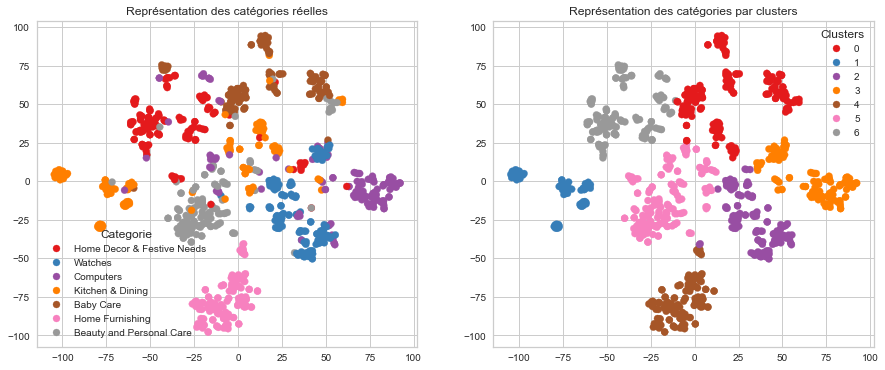

ARI :  0.6163


In [116]:
perplexity = 10
TSNE_visu_fct(ARI_results[perplexity]['X_tsne'], y_cat_num, ARI_results[perplexity]['labels'], ARI_results[perplexity]['ARI'])

### Score ARI :tfidf_3gram

In [117]:
ARI_results = {}
for i in [5, 10, 20, 30, 40]:
    ARI, X_tsne, labels = ARI_fct(df_tfidf_3gram, i )
    ARI_results[i] = {'ARI': ARI,'X_tsne' : X_tsne, 'labels': labels}
    
# print(ARI_results)


[ARI_fct]  perplexity : 5   ARI :  0.2494 time :  8.0
[ARI_fct]  perplexity : 10   ARI :  0.3416 time :  8.0
[ARI_fct]  perplexity : 20   ARI :  0.352 time :  8.0
[ARI_fct]  perplexity : 30   ARI :  0.3628 time :  10.0
[ARI_fct]  perplexity : 40   ARI :  0.3477 time :  12.0


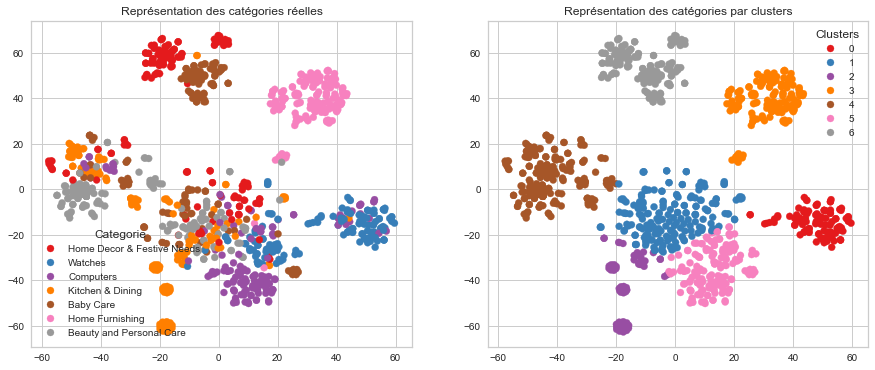

ARI :  0.3628


In [118]:
perplexity = 30
TSNE_visu_fct(ARI_results[perplexity]['X_tsne'], y_cat_num, ARI_results[perplexity]['labels'], ARI_results[perplexity]['ARI'])

### Score ARI : embeddings_word2vec

In [119]:
ARI_results = {}
for i in [5, 10, 20, 30, 40]:
    ARI, X_tsne, labels = ARI_fct(embeddings_word2vec, i )
    ARI_results[i] = {'ARI': ARI,'X_tsne' : X_tsne, 'labels': labels}
    
# print(ARI_results)

[ARI_fct]  perplexity : 5   ARI :  0.1968 time :  8.0
[ARI_fct]  perplexity : 10   ARI :  0.2262 time :  8.0
[ARI_fct]  perplexity : 20   ARI :  0.2515 time :  10.0
[ARI_fct]  perplexity : 30   ARI :  0.2026 time :  12.0
[ARI_fct]  perplexity : 40   ARI :  0.2338 time :  11.0


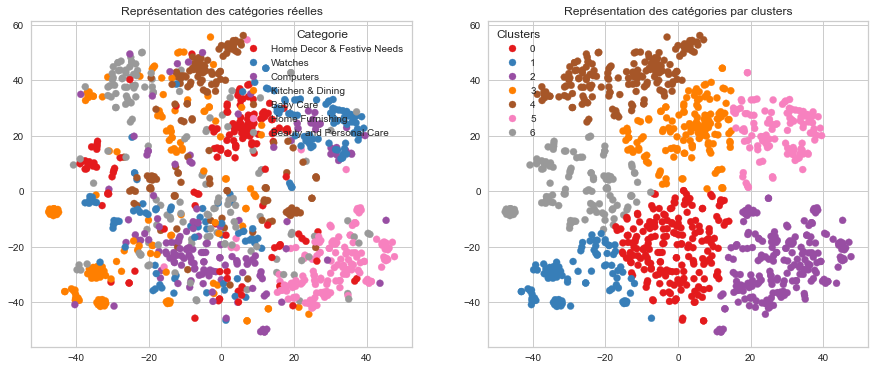

ARI :  0.2515


In [120]:
perplexity = 20
TSNE_visu_fct(ARI_results[perplexity]['X_tsne'], y_cat_num, ARI_results[perplexity]['labels'], ARI_results[perplexity]['ARI'])

### Score ARI : Bert

In [121]:
ARI_results = {}
for i in [5, 10, 20, 30, 40]:
    ARI, X_tsne, labels = ARI_fct(features_bert, i )
    ARI_results[i] = {'ARI': ARI,'X_tsne' : X_tsne, 'labels': labels}
    
# print(ARI_results)

[ARI_fct]  perplexity : 5   ARI :  0.2886 time :  7.0
[ARI_fct]  perplexity : 10   ARI :  0.286 time :  7.0
[ARI_fct]  perplexity : 20   ARI :  0.2887 time :  9.0
[ARI_fct]  perplexity : 30   ARI :  0.2917 time :  8.0
[ARI_fct]  perplexity : 40   ARI :  0.3097 time :  11.0


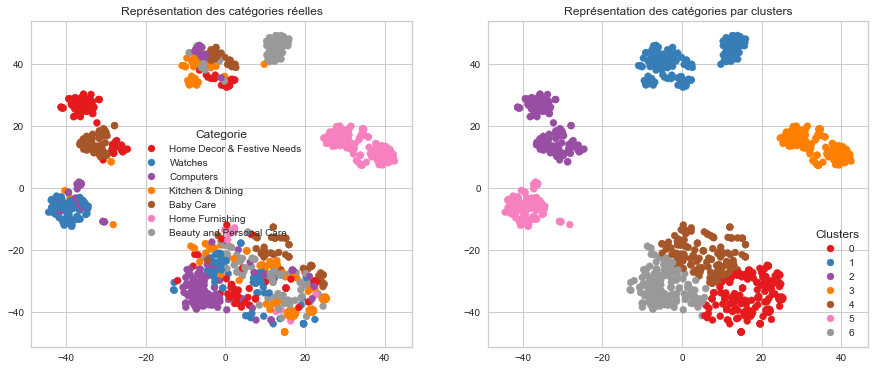

ARI :  0.3097


In [122]:
perplexity = 40
TSNE_visu_fct(ARI_results[perplexity]['X_tsne'], y_cat_num, ARI_results[perplexity]['labels'], ARI_results[perplexity]['ARI'])

### Score ARI : USE - Universal Sentence Encoder

In [123]:
ARI_results = {}
for i in [5, 10, 20, 30, 40]:
    ARI, X_tsne, labels = ARI_fct(features_USE, i )
    ARI_results[i] = {'ARI': ARI,'X_tsne' : X_tsne, 'labels': labels}
    
# print(ARI_results)

[ARI_fct]  perplexity : 5   ARI :  0.3475 time :  7.0
[ARI_fct]  perplexity : 10   ARI :  0.4307 time :  8.0
[ARI_fct]  perplexity : 20   ARI :  0.4366 time :  8.0
[ARI_fct]  perplexity : 30   ARI :  0.3712 time :  10.0
[ARI_fct]  perplexity : 40   ARI :  0.3784 time :  11.0


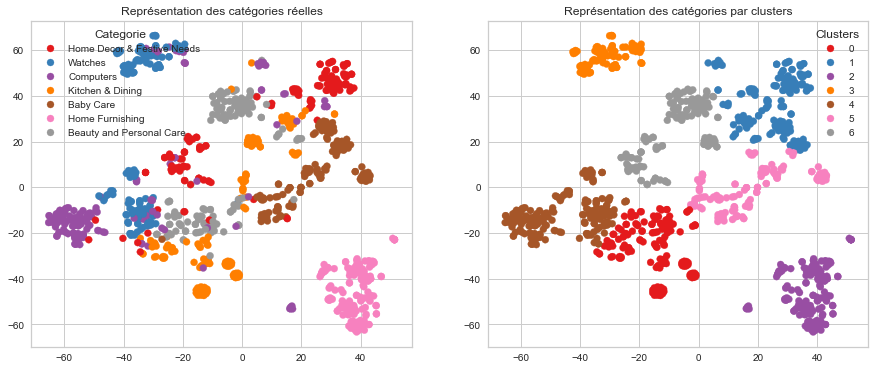

ARI :  0.4366


In [124]:
perplexity = 20
TSNE_visu_fct(ARI_results[perplexity]['X_tsne'], y_cat_num, ARI_results[perplexity]['labels'], ARI_results[perplexity]['ARI'])

## <font color='red'> - Preprocessing et extraction des features images :</font> 

### Import du dataset

In [125]:
! pip install opencv-python

In [126]:
! pip install opencv-contrib-python


In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from os import listdir

path = "C:/Users/chouc/openclassrooms/projet6/Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [128]:
list_photos

['009099b1f6e1e8f893ec29a7023153c4.jpg',
 '0096e89cc25a8b96fb9808716406fe94.jpg',
 '00cbbc837d340fa163d11e169fbdb952.jpg',
 '00d84a518e0550612fcfcba3b02b6255.jpg',
 '00e966a5049a262cfc72e6bbf68b80e7.jpg',
 '00ed03657cedbe4663eff2d7fa702a33.jpg',
 '01089dc3618a0ab7304d784ef400b83d.jpg',
 '0131e5d87b72877702d536299cf83b75.jpg',
 '020d2daba55a723128e4e07c0b0393a9.jpg',
 '02127f52e96fb72c66bf081d25104ef8.jpg',
 '025a85a3d1cddc6307f7dc075d8d2132.jpg',
 '02a53d335775b652f22f41b529b9d646.jpg',
 '02c63a087b298ec74042d557acf61be1.jpg',
 '031c98cfde349d99fb6d5983f54c8751.jpg',
 '032e812adcd11a38fd8b764891a852ff.jpg',
 '037b39bef3db7ccd264c577a0edf0c0a.jpg',
 '037c2402fee39fbc80433935711d1383.jpg',
 '04f9f818e2d657b873b07578cfe2eade.jpg',
 '04f9ff160a1561e3656350f4bd6b8c50.jpg',
 '050ea3acb555bf641e7ae9b4f3ba684a.jpg',
 '052559ede419996737893eb47568ee7f.jpg',
 '057836ecde71565f8ebdd576e41fdc96.jpg',
 '059493eeb88ebb4cc08d1522f3f87c3f.jpg',
 '059bc43e03e1824a9ab6466e32e5f137.jpg',
 '06749cbff1487f

### Détermination et affichage des descripteurs SIFT (exemple)

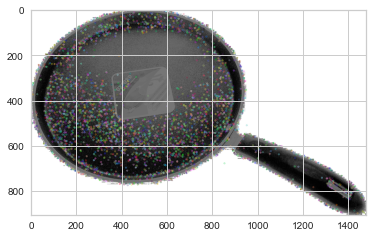

Descripteurs :  (4656, 128)

[[ 4.  2.  6. ...  5.  0.  0.]
 [96. 20.  0. ...  9.  2.  0.]
 [55. 16.  0. ...  0.  1.  0.]
 ...
 [12.  0.  0. ...  0.  0.  0.]
 [67. 19.  5. ...  0. 34. 13.]
 [ 0.  5. 27. ...  0.  0.  0.]]


In [129]:
import cv2

sift = cv2.SIFT_create()
image = cv2.imread(path+list_photos[1],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


- L'image contient 4656 descripteurs
- Chaque descripteur est un vecteur de longueur 128

### Pré-traitement des images via SIFT

#### Créations des descripteurs de chaque image

* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [130]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\3880497225.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)



Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :           786.68 secondes


### Création des clusters de descripteurs

- Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

Nombre de cluster = racine carré du nombre total des descripteurs (nombre maximale de cluster pour avoir assez pour ne pas perdre de l'information   )
ou
Nombre de cluster = nombre des catégories qu'on va classifier les images* 10 ( 10 fois le nombre = nombre minimale)

In [131]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...


C:\Users\chouc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


temps de traitement kmeans :            11.33 secondes


### Création des features des images

* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [132]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            98.69 secondes


### Réductions de dimension

#### Réduction de dimension T-SNE

- Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [133]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(im_features)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df['category_1']
print(df_tsne.shape)


C:\Users\chouc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


### Analyse visuelle : affichage T-SNE selon catégories d'images

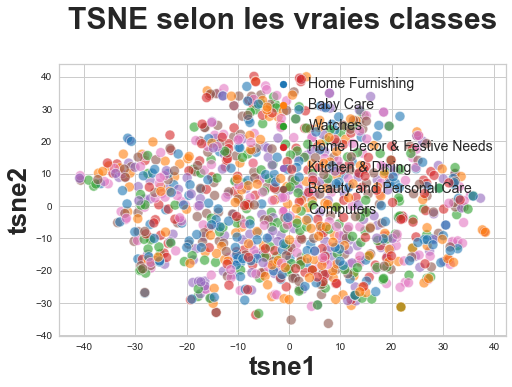

In [134]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=100, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()




## Analyse mesures : similarité entre catégories et clusters

### Création de clusters à partir du T-SNE

In [135]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


### Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

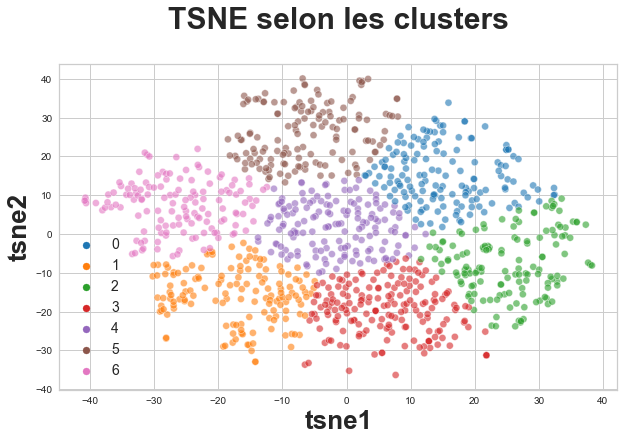

ARI :  0.0003947825876347381


In [136]:

plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df['category_1']
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Le score ARI est trés faible

# ORB

In [137]:
# identification of key points and associated descriptors
import time, cv2
ORB_keypoints = []
temps1=time.time()
ORB = cv2.ORB_create()

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = ORB.detectAndCompute(res, None)
    ORB_keypoints.append(des)

ORB_keypoints_by_img = np.asarray(ORB_keypoints)
ORB_keypoints_all    = np.concatenate(ORB_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", ORB_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement ORB descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (520145, 32)
temps de traitement ORB descriptor :            42.88 secondes


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17320\2556518826.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ORB_keypoints_by_img = np.asarray(ORB_keypoints)


#### Création des clusters de descripteurs

In [138]:
# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(ORB_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(ORB_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

C:\Users\chouc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Nombre de clusters estimés :  721
Création de 721 clusters de descripteurs ...
temps de traitement kmeans :             8.43 secondes


#### Création des features des images

In [139]:
# Creation of histograms (features)
temps1=time.time()


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(ORB_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features_ORB = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :           102.44 secondes


#### Réduction de dimension T-SNE

In [140]:
X_tsne_ORB = tsne.fit_transform(im_features_ORB)

df_tsne_ORB = pd.DataFrame(X_tsne_ORB[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_ORB["class"] = df['category_1']
print(df_tsne_ORB.shape)

C:\Users\chouc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


#### Création de clusters à partir du T-SNE

In [141]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne_ORB)

df_tsne_ORB["cluster"] = cls.labels_
print(df_tsne_ORB.shape)

(1050, 4)


#### Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

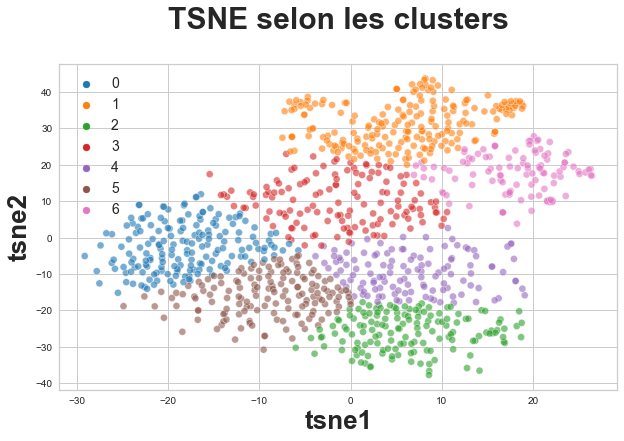

ARI :  0.0005614022550997109


In [142]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_ORB,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df['category_1']
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

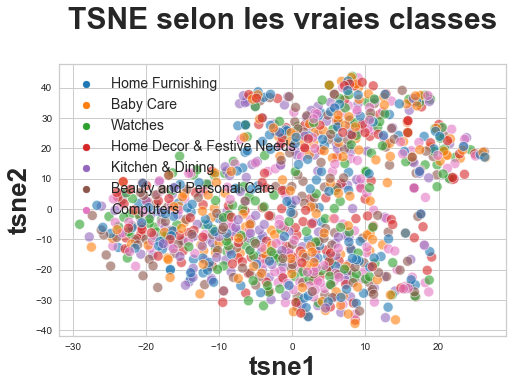

In [143]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_ORB, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=100, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

## CNN

In [144]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [145]:
for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert the image to Tensor
    img_to_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
# print the converted Torch tensor
print(img_to_tensor)

print("dtype of tensor:",img_to_tensor.dtype)


0
100
200
300
400
500
600
700
800
900
1000
tf.Tensor(
[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [125. 125. 125.]
  [125. 125. 125.]
  [125. 125. 125.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [125. 125. 125.]
  [125. 125. 125.]
  [125. 125. 125.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [125. 125. 125.]
  [125. 125. 125.]
  [125. 125. 125.]]], shape=(904, 1478, 3), dtype=float32)
dtype of tensor: <dtype: 'float32'>


In [146]:
img_to_tensor.shape

TensorShape([904, 1478, 3])

In [147]:
# resize tensor to 224 x 224
tensor = tf.image.resize(img_to_tensor, [224, 224])

In [148]:
tensor.shape

TensorShape([224, 224, 3])

In [149]:
# add another dimension at the front to get NHWC shape
input_tensor = tf.expand_dims(tensor, axis=0)
# (1, 224, 224, 3)

In [150]:
input_tensor.shape

TensorShape([1, 224, 224, 3])

In [151]:
from keras import applications

# getting the convolutional base of a ResNet50 CNN
conv_base = applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
    
)


In [152]:
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D
from keras.layers import Flatten

# conv_base.trainable = False
# use the sequential API to use the .add method
cnn_model = Sequential()
cnn_model.add(conv_base)

# add layer for dimensional reduction and flattening
# cnn_model.add(GlobalMaxPooling2D())
cnn_model.add(Flatten())

cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [153]:
! pip install pydot
! pip install pydotplus


In [154]:
conda install graphviz

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [155]:
from keras.utils import plot_model

In [156]:
from keras.utils.vis_utils import plot_model

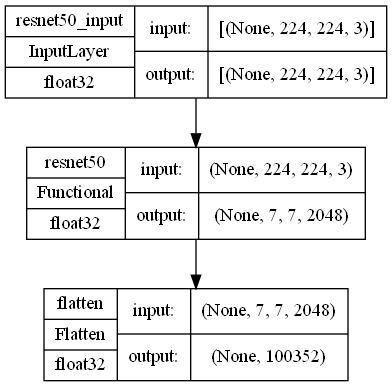

In [157]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True, show_dtype=True)

In [158]:
for i, layer in enumerate(cnn_model.layers):
    print(i, layer.name, layer.output_shape, layer.trainable)

0 resnet50 (None, 7, 7, 2048) True
1 flatten (None, 100352) True


In [159]:
features_list = [layer.output for layer in cnn_model.layers]

In [160]:
inputs=cnn_model.inputs

In [161]:
inputs

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'resnet50_input')>]

In [162]:
# feature_extractor = tf.keras.Model(
#     inputs=cnn_model.inputs,
#     outputs=[layer.output for layer in cnn_model.layers],
# )

# Call feature extractor on test input.
# x = input_tensor
# features = feature_extractor(x)

In [163]:
import cv2
import os
#  path = "C:/Users/chouc/openclassrooms/projet6/Images/"
# list_photos = [file for file in listdir(path)]
# print(len(list_photos))
    
dir_name = "C:/Users/chouc/openclassrooms/projet6/Images/"

# for each product
for img_file_name in df['image']:
  #     get the file path of the image  
    
    file_path = os.path.join(dir_name, img_file_name)
    
#     open the image as a np.darray
    img = cv2.imread(file_path)
    
#     reshape the image to get a tensor
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    tensor = tf.image.resize(img, [224, 224])
    
#     get the featyre extracted from the convolutional base
    
    features_img = cnn_model.predict(tensor)
    
    
        
# check if 'img_CNN' exists or not 
    
    
    if 'img_CNN' not in locals() :     
#         create the features_CNN variable 
        img_CNN = features_img
        
    else :
#         concatenate the features_img to features_CNN
        img_CNN = np.concatenate((features_img, img_CNN), axis = 0)
    


    
    

      



1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 156ms/step


In [164]:
img_CNN.shape

(1050, 100352)

In [165]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=40, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(img_CNN)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df['category_1']
print(df_tsne.shape)

C:\Users\chouc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


In [166]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


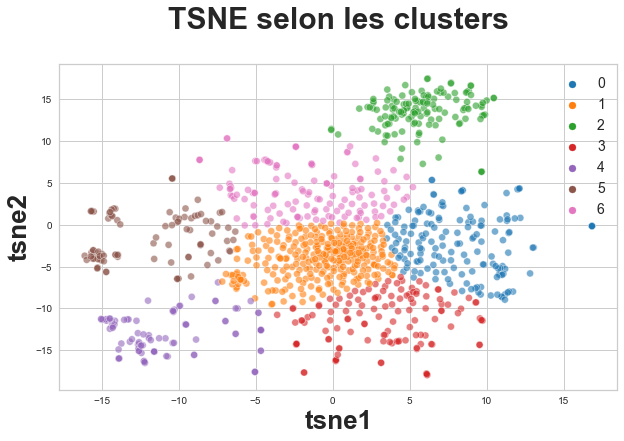

ARI :  0.017785750714317393


In [167]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df['category_1']
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

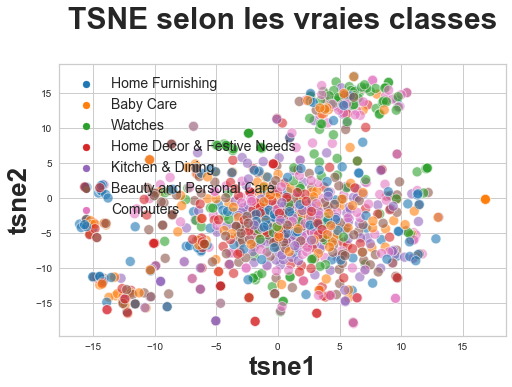

In [168]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=100, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

#### Réduction de dimenssion avec NMF

In [169]:
from sklearn.decomposition import NMF
model = NMF(n_components=7, init='random', random_state=0)
X_NMF = model.fit_transform(img_CNN)
# H = model.components_

In [170]:
cls = KMeans(n_clusters=7, random_state=0)
cls.fit(X_NMF)

KMeans(n_clusters=7, random_state=0)

In [171]:
# predict cluster labels for new dataset
cls.predict(X_NMF)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([2, 3, 2, ..., 3, 4, 0])

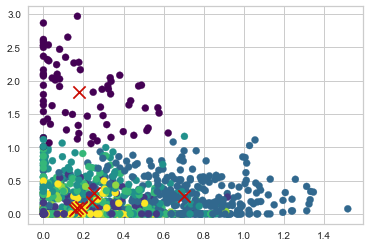

In [172]:
plt.scatter(X_NMF[:,0], X_NMF[:,1], c=cls.predict(X_NMF), cmap='viridis')
plt.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:,1], marker='x', s=150, c='r')

In [173]:
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

ARI :  0.024923958045955368


#### Réduction de dimenssion avec PCA

In [174]:
# PCA Pipeline
pca =  PCA(svd_solver='full')
            
pca.fit(img_CNN)
X_projected = pca.transform(img_CNN)

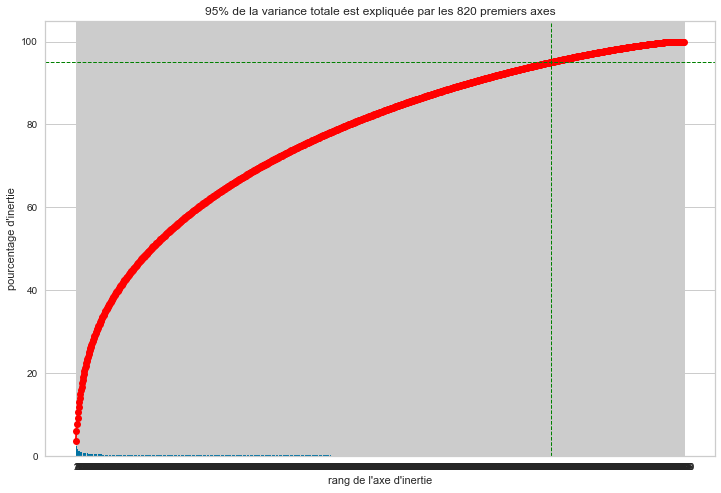

In [175]:
# Explained variance
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)


plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [176]:
cls = KMeans(n_clusters=7, random_state=0)
cls.fit(X_projected)

KMeans(n_clusters=7, random_state=0)

In [177]:
# predict cluster labels for new dataset
cls.predict(X_projected)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([1, 1, 1, ..., 3, 3, 6])

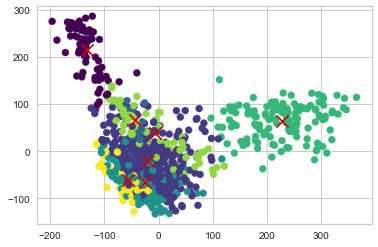

In [178]:
plt.scatter(X_projected[:,0], X_projected[:,1], c=cls.predict(X_projected), cmap='viridis')
plt.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:,1], marker='x', s=150, c='r')

In [179]:
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

ARI :  0.01395152335915792


# VGG16

In [180]:
from keras.applications.vgg16 import VGG16

conv_base1 = VGG16(weights='imagenet', include_top=True) # Création du modèle VGG-16 implementé par Keras

In [181]:

from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D
from keras.layers import Flatten

# conv_base.trainable = False
# use the sequential API to use the .add method
cnn_model1 = Sequential()
cnn_model1.add(conv_base1)

# add layer for dimensional reduction and flattening
# cnn_model1.add(GlobalMaxPooling2D())
cnn_model1.add(Flatten())

cnn_model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
Total params: 138,357,544
Trainable params: 138,357,544
Non-trainable params: 0
_________________________________________________________________


In [182]:
# from keras.utils import load_img, img_to_array
# from keras.applications.vgg16 import preprocess_input

# img = load_img('cat01.jpg', target_size=(224, 224))  # Charger l'image
# img = img_to_array(img)  # Convertir en tableau numpy
# img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
# img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

In [183]:
import cv2
import os
from keras.applications.vgg16 import preprocess_input
#  path = "C:/Users/chouc/openclassrooms/projet6/Images/"
# list_photos = [file for file in listdir(path)]
# print(len(list_photos))
    
dir_name = "C:/Users/chouc/openclassrooms/projet6/Images/"

# for each product
for img_file_name in df['image']:
  #     get the file path of the image  
    
    file_path = os.path.join(dir_name, img_file_name)
    
#     open the image as a np.darray
    img = cv2.imread(file_path)
    
#     reshape the image to get a tensor
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    img = tf.image.resize(img, [224, 224])
    img = preprocess_input(img)
    
#     get the featyre extracted from the convolutional base
    
    features_img1 = cnn_model1.predict(img)
    
    
        
# check if 'img_CNN' exists or not 
    
    
    if 'img_CNN1' not in locals() :     
#         create the features_CNN variable 
        img_CNN1 = features_img1
        
    else :
#         concatenate the features_img to features_CNN
        img_CNN1 = np.concatenate((features_img1, img_CNN1), axis = 0)
    

1/1 [==============================] - 0s 244ms/step


1/1 [==============================] - 0s 321ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 424ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 468ms/step


1/1 [==============================] - 0s 435ms/step


In [184]:
img_CNN1.shape

(1050, 1000)

In [185]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=40, 
                     n_iter=2000, init='random', random_state=6)
X_tsne_vgg = tsne.fit_transform(img_CNN1)

df_tsne_vgg = pd.DataFrame(X_tsne_vgg[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_vgg["class"] = df['category_1']
print(df_tsne_vgg.shape)

C:\Users\chouc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


In [186]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne_vgg)

df_tsne_vgg["cluster"] = cls.labels_
print(df_tsne_vgg.shape)

(1050, 4)


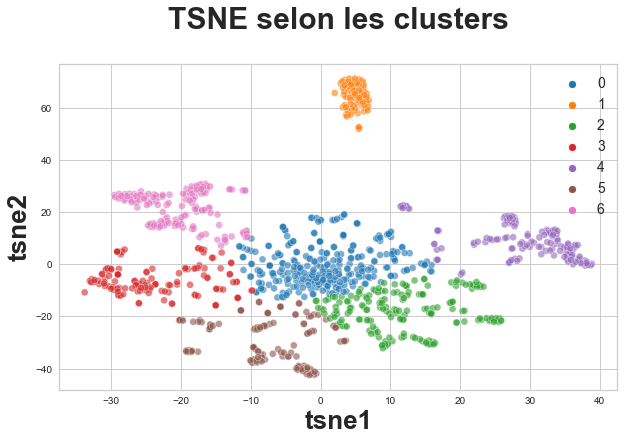

ARI :  0.024515696144419123


In [187]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne_vgg,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df['category_1']
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

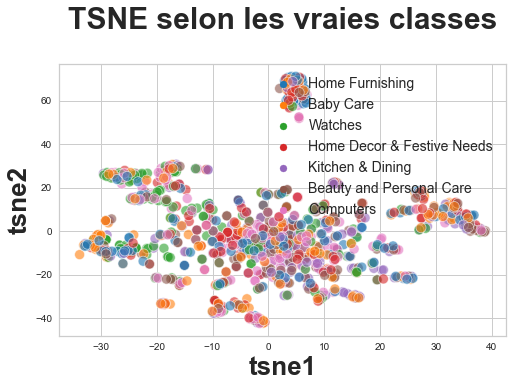

In [188]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_vgg, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=100, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

#### VGG16 : Réduction de dimenssion avec NMF 

In [189]:
from sklearn.decomposition import NMF
model = NMF(n_components=7, init='random', random_state=0)
X_NMF = model.fit_transform(img_CNN1)
# H = model.components_

In [190]:
cls = KMeans(n_clusters=7, random_state=0)
cls.fit(X_NMF)

KMeans(n_clusters=7, random_state=0)

In [191]:
# predict cluster labels for new dataset
cls.predict(X_NMF)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([0, 0, 0, ..., 0, 0, 0])

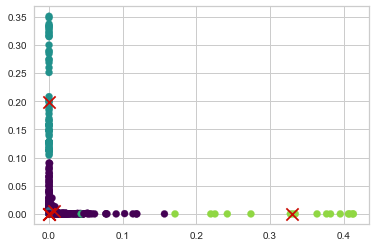

In [192]:
plt.scatter(X_NMF[:,0], X_NMF[:,1], c=cls.predict(X_NMF), cmap='viridis')
plt.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:,1], marker='x', s=150, c='r')

In [193]:
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

ARI :  0.0117189195928358


#### VGG16 : Réduction de dimenssion avec PCA

In [194]:
# PCA Pipeline
pca =  PCA(svd_solver='full')
            
pca.fit(img_CNN1)
X_projected = pca.transform(img_CNN1)

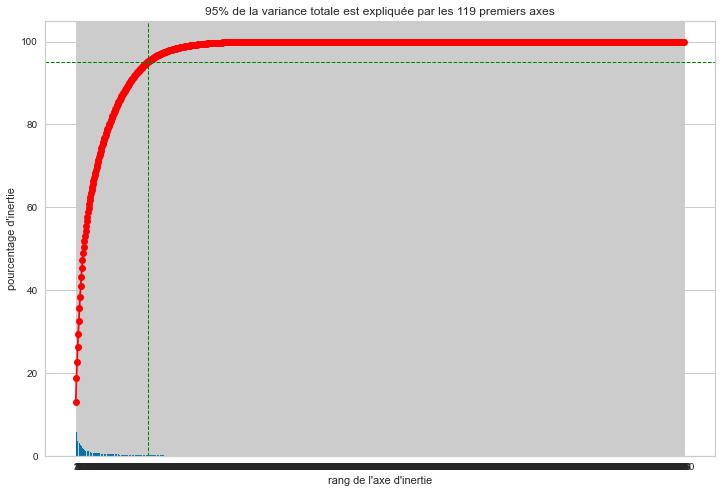

In [195]:
# Explained variance
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)


plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [196]:
cls = KMeans(n_clusters=7, random_state=0)
cls.fit(X_projected)

KMeans(n_clusters=7, random_state=0)

In [197]:
# predict cluster labels for new dataset
cls.predict(X_projected)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([1, 1, 1, ..., 1, 1, 1])

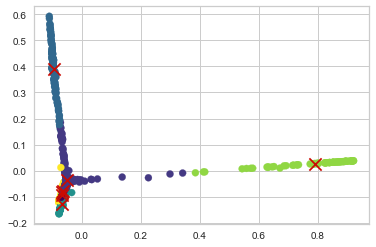

In [198]:
plt.scatter(X_projected[:,0], X_projected[:,1], c=cls.predict(X_projected), cmap='viridis')
plt.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:,1], marker='x', s=150, c='r')

In [199]:
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

ARI :  0.011974954318497762
